# Total Deaths 2020
### In this analysis, we will analyze the following:
* How different the number of deaths were in the United States for the years 2015 to present and compare them.
* The total number of deaths per jurisdiction, per cause, per year.

## Import libraries
We first need to import Python libraries that will be used with our data analyses and load in the deaths by jurisdiction and cause csv file directly from the source, https://data.cdc.gov/NCHS/Weekly-Counts-of-Death-by-Jurisdiction-and-Select-/u6jv-9ijr?fbclid=IwAR3oPM9rkxOVoZ4PRdfaGAvzLJy7kSPU3ymb1metm1R2vvAl6dAPE53OaKU 

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import display
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

## Read in .csv file

In [2]:
data = pd.read_csv("https://data.cdc.gov/api/views/u6jv-9ijr/rows.csv?accessType=DOWNLOAD&bom=true&format=true")

In [3]:
data.head()

,Jurisdiction,Week Ending Date,State Abbreviation,Year,Week,Cause Group,Number of Deaths,Cause Subgroup,Time Period,Suppress,Note,Average Number of Deaths in Time Period,Difference from 2015-2019 to 2020,Percent Difference from 2015-2019 to 2020,Type
0,Alabama,2015-01-10,AL,2015,1,Alzheimer disease and dementia,120.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
1,Alabama,2015-01-10,AL,2015,1,Alzheimer disease and dementia,120.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
2,Alabama,2016-01-09,AL,2016,1,Alzheimer disease and dementia,76.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
3,Alabama,2016-01-09,AL,2016,1,Alzheimer disease and dementia,76.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
4,Alabama,2017-01-07,AL,2017,1,Alzheimer disease and dementia,96.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)


## Data cleanup
### Drop uneeded columns
Lets drop all of the columns that will not be needed in our data analyses. We are interested in Jurisdiction, Year, and Cause Group so we will drop every other column.

In [4]:
data.drop('Week Ending Date', axis = 1, inplace = True)
data.drop('State Abbreviation', axis = 1, inplace = True)
data.drop('Week', axis = 1, inplace = True)
data.drop('Cause Subgroup', axis = 1, inplace = True)
data.drop('Time Period', axis = 1, inplace = True)
data.drop('Suppress', axis = 1, inplace = True)
data.drop('Note', axis = 1, inplace = True)
data.drop('Average Number of Deaths in Time Period', axis = 1, inplace = True)
data.drop('Difference from 2015-2019 to 2020', axis = 1, inplace = True)
data.drop('Percent Difference from 2015-2019 to 2020', axis = 1, inplace = True)
data.drop('Type', axis = 1, inplace = True)

We will check for missing values and handle them.

In [5]:
data.isnull().sum()

Jurisdiction          0
Year                  0
Cause Group           0
Number of Deaths    153
dtype: int64

Lets look at these null values.

In [6]:
data[data.isna().any(axis=1)]["Jurisdiction"].unique()

array(['North Carolina'], dtype=object)

Lets replace these null values with the median from every year for every cause of death and check for null values again.

In [7]:
data["Number of Deaths"] = data.groupby(["Jurisdiction", "Year", "Cause Group"]).transform(lambda x: x.fillna(int(x.median())))

In [8]:
data.isna().sum()

Jurisdiction        0
Year                0
Cause Group         0
Number of Deaths    0
dtype: int64

Lets check the data types.

In [9]:
data.dtypes

Jurisdiction         object
Year                  int64
Cause Group          object
Number of Deaths    float64
dtype: object

'Number of Deaths' is of type float and should be of type int so lets change it and check the data types again.

In [10]:
data = data.astype({'Number of Deaths':'int'})
data.dtypes

Jurisdiction        object
Year                 int64
Cause Group         object
Number of Deaths     int64
dtype: object

Lets check for strange values.

In [11]:
data.describe()

,Year,Number of Deaths
count,359784.000000,359784.000000
mean,2017.799463,157.924177
std,1.894070,683.109181
min,2015.000000,11.000000
25%,2016.000000,23.000000
50%,2018.000000,44.000000
75%,2019.000000,95.000000
max,2021.000000,12433.000000


Lets see how many rows have a jurisdiction that is 'United States'.

In [12]:
display(data[data['Jurisdiction'] == 'United States'].head())
display(data[data['Jurisdiction'] == 'United States'].count())

,Jurisdiction,Year,Cause Group,Number of Deaths
29528,United States,2015,Alzheimer disease and dementia,6187
29529,United States,2015,Alzheimer disease and dementia,6187
29530,United States,2016,Alzheimer disease and dementia,5155
29531,United States,2016,Alzheimer disease and dementia,5155
29532,United States,2017,Alzheimer disease and dementia,5844


Jurisdiction        8866
Year                8866
Cause Group         8866
Number of Deaths    8866
dtype: int64

We need specific jurisdictions so lets drop all of the rows that contain 'United States' in the 'Jurisdiction' column and check if they are gone. We are dropping these because if we don't, they will be duplicated.

In [13]:
index = data[(data['Jurisdiction'] == 'United States')].index
data.drop(index, inplace = True)
display(data[data['Jurisdiction'] == 'United States'].count())

Jurisdiction        0
Year                0
Cause Group         0
Number of Deaths    0
dtype: int64

Before we analyze this data, Python likes it better when variables do not have spaces, so lets get rid of the spaces.

In [14]:
data.columns = ['Jurisdiction', 'Year', 'CauseGroup', 'NumberOfDeaths']
data.head()

,Jurisdiction,Year,CauseGroup,NumberOfDeaths
0,Alabama,2015,Alzheimer disease and dementia,120
1,Alabama,2015,Alzheimer disease and dementia,120
2,Alabama,2016,Alzheimer disease and dementia,76
3,Alabama,2016,Alzheimer disease and dementia,76
4,Alabama,2017,Alzheimer disease and dementia,96


Since the data looks good, we can now start analyzing the dataset.

## Dataset Analyses
###### Dataset: Weekly_counts_of_death_by_jurisdiction_and_cause_of_death analyses
### Seperate data by year
The data needs to be seperated by year so we can analyze deaths per year. We will create a new dataframe for every year in the data called 'df_year' replacing year with the actual year.

In [15]:
for year in data['Year'].unique():
    globals()['df_%s' % year] = data[data.Year == year].reset_index(drop = True)

Lets sum the total number of deaths for all years and total number of deaths per year. We will store the values for total deaths in a variable called 'totalDeaths_all' and store each years total deaths in a seperate variable called 'sum_year' replacing year with the actual year. 

In [16]:
sum_years = data.groupby([data.Year]).sum()

totalDeaths_all = int(sum(sum_years['NumberOfDeaths']))

i = 0
for year in sum_years.index:
    globals()['sum_%s' % year] = int(sum_years.iloc[i])
    i+=1

We will now create a dataframe of years and deaths to analyze and compare and visualize it with a bar plot.

,Year,Deaths,Rate
0,2015,4169642,0.14754
1,2016,4185802,0.14811
2,2017,4301084,0.15219
3,2018,4343762,0.15370
4,2019,4341442,0.15362
5,2020,4636278,0.16405
6,2021,2283113,0.08079


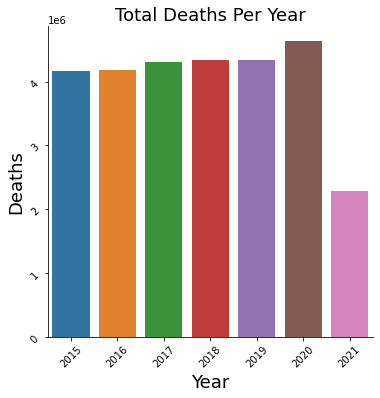

In [17]:
years = data['Year'].unique()

years_total = []
for year in years:
    years_total.append(str(year))
years_total.append('Total')

deaths = [item for item in sum_years['NumberOfDeaths']]
deaths.append(totalDeaths_all)

rate = []

for i in range(len(deaths)-1):
    rate.append(round(deaths[i]/totalDeaths_all, 5))
    
rateSum = sum(rate)
rate.append(rateSum)

df_deaths = np.array([years_total, deaths, rate]).T
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Year', 'Deaths', 'Rate']

df_ndeaths = df_deaths

df_ndeaths.drop(df_ndeaths.tail(1).index,inplace=True) # drop first n rows

df_ndeaths = df_ndeaths.astype({'Year':'int', 'Deaths':'int', 'Rate':'float'})

display(df_ndeaths)

sns.catplot(x = 'Year', y = 'Deaths', kind = 'bar', data = df_ndeaths)
plt.title("Total Deaths Per Year", size=18)
plt.xlabel("Year", size=18)
plt.ylabel("Deaths", size=18)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


### Deaths by cause and year
Lets analyze deaths by cause and year. We will seperate each year by cause, create a dataframe and plot the results.

,Year,Alzheimer,Circulatory,Malignant,Other,Respiratory
0,2015,490130,1649122,1196044,314026,520320
1,2016,498712,1658800,1200410,315756,512124
2,2017,525012,1702588,1207174,326626,539684
3,2018,535206,1722914,1207218,330710,547714
4,2019,544754,1733834,1208100,331254,523500
5,2020,621426,1875180,1233371,373981,532320
6,2021,287888,937930,629774,187997,239524


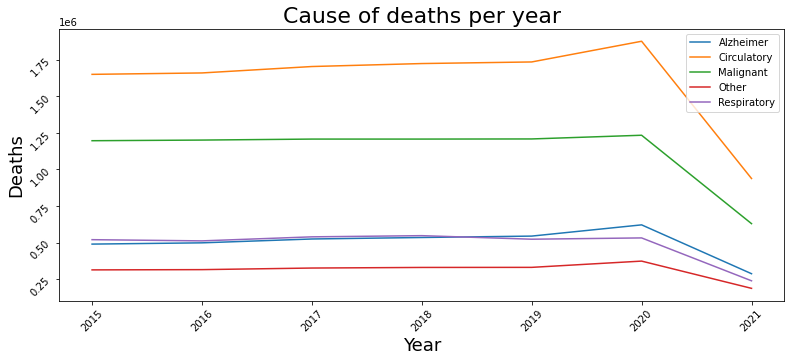

In [18]:
# Get Alzheimer deaths per year and store in a variable called 'deathsAlzheimer_year' where year is the actual year
for year in data['Year'].unique():
    globals()['deathsAlzheimer_%s' % year] = int(data.query(f"CauseGroup == 'Alzheimer disease and dementia' and Year == {year}")['NumberOfDeaths'].sum())

# Get Malignant deaths per year and store in a variable called 'deathsMalignant_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsMalignant_%s' % year] = int(data.query(f"CauseGroup == 'Malignant neoplasms' and Year == {year}")['NumberOfDeaths'].sum())

# Get Respiratory deaths per year and store in a variable called 'deathsRespiratory_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsRespiratory_%s' % year] = int(data.query(f"CauseGroup == 'Respiratory diseases' and Year == {year}")['NumberOfDeaths'].sum())

# Get Circulatory deaths per year and store in a variable called 'deathsCirculatory_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsCirculatory_%s' % year] = int(data.query(f"CauseGroup == 'Circulatory diseases' and Year == {year}")['NumberOfDeaths'].sum())
    
# Get Other deaths per year and store in a variable called 'deathsOther_year' where year is the actual year                                                           
for year in data['Year'].unique():
    globals()['deathsOther_%s' % year] = int(data.query(f"CauseGroup == 'Other select causes' and Year == {year}")['NumberOfDeaths'].sum())

yearCauseDeaths = data.groupby([data.Year, data.CauseGroup]).sum().reset_index()

myDict = {}
for i in range(len(yearCauseDeaths)):
    if myDict == {}:
        myDict = {yearCauseDeaths.iloc[i,0]:[yearCauseDeaths.iloc[i,-1]]}
    else:
        if yearCauseDeaths.iloc[i,0] in myDict.keys():
            myDict[yearCauseDeaths.iloc[i,0]].append(yearCauseDeaths.iloc[i,-1])
        else:
            myDict.update({yearCauseDeaths.iloc[i,0]:[yearCauseDeaths.iloc[i,-1]]})

colNames = yearCauseDeaths["CauseGroup"].unique()
col_names = []

for item in colNames:
    col_names.append(item.split(" ")[0])

df_deathsCausePerYear = pd.DataFrame(myDict.values(), columns = col_names)
df_deathsCausePerYear

years = myDict.keys()

df_deathsCausePerYear.insert(0, "Year", years)

display(df_deathsCausePerYear)

fig = plt.gcf()
fig.set_size_inches(13, 5)
plt.plot(df_deathsCausePerYear.Year, "Alzheimer", data = df_deathsCausePerYear)
plt.plot(df_deathsCausePerYear.Year, "Circulatory", data = df_deathsCausePerYear)
plt.plot(df_deathsCausePerYear.Year, "Malignant", data = df_deathsCausePerYear)
plt.plot(df_deathsCausePerYear.Year, "Other", data = df_deathsCausePerYear)
plt.plot(df_deathsCausePerYear.Year, "Respiratory", data = df_deathsCausePerYear)
plt.title("Cause of deaths per year", size = 22)
plt.xlabel("Year", size = 18)
plt.ylabel("Deaths", size = 18)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.legend()
plt.show()


From the results of Deaths Per Cause Per Year, we can see that the number of deaths increase every year in every cause except respiratory. Respiratory deaths are the only cause that the number of deaths decrease and increase but it stays consistent. We can visualize that circulatory deaths are the number one cause of deaths every year followed by malignant and then alzheimer and respiratory are about the same.

### Total deaths by cause
Now, lets analyze deaths by cause, create a dataframe and plot the results in a pie plot.

,Cause,Deaths,Rate
0,Circulatory,11280368,0.3991
1,Malignant,7882091,0.2789
2,Respiratory,3415186,0.1208
3,Alzheimer,3503128,0.1240
4,Other,2180350,0.0772


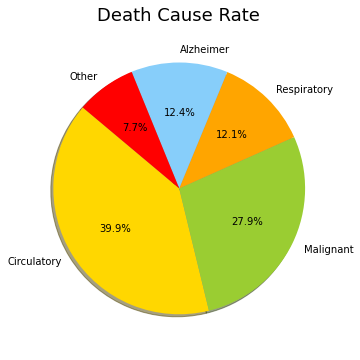

In [19]:
deaths_alzheimer = int(data.loc[data['CauseGroup'] == 'Alzheimer disease and dementia', 'NumberOfDeaths'].sum())
deaths_malignant = int(data.loc[data['CauseGroup'] == 'Malignant neoplasms', 'NumberOfDeaths'].sum())
deaths_respiratory = int(data.loc[data['CauseGroup'] == 'Respiratory diseases', 'NumberOfDeaths'].sum())
deaths_circulatory = int(data.loc[data['CauseGroup'] == 'Circulatory diseases', 'NumberOfDeaths'].sum())
deaths_other = int(data.loc[data['CauseGroup'] == 'Other select causes', 'NumberOfDeaths'].sum())

array_circulatory = ['Circulatory', deaths_circulatory, round(deaths_circulatory/totalDeaths_all, 4)]
array_malignant = ['Malignant', deaths_malignant, round(deaths_malignant/totalDeaths_all, 4)]
array_respiratory = ['Respiratory', deaths_respiratory, round(deaths_respiratory/totalDeaths_all, 4)]
array_alzheimer = ['Alzheimer', deaths_alzheimer, round(deaths_alzheimer/totalDeaths_all, 4)]
array_other = ['Other', deaths_other, round(deaths_other/totalDeaths_all, 4)]

df_cause = pd.DataFrame([array_circulatory, array_malignant, array_respiratory, array_alzheimer, array_other])

df_cause.columns = ['Cause', 'Deaths', 'Rate']

display(df_cause)

fig, ax = plt.subplots(figsize = (5, 6), subplot_kw = dict(aspect = "equal"))

labels = df_cause['Cause']
sizes = df_cause['Rate']
colors = ['gold', 'yellowgreen', 'orange', 'lightskyblue', 'red']

# Plot
plt.pie(sizes, labels = labels, colors = colors,
autopct='%1.1f%%', shadow = True, startangle=140)

plt.axis('equal')
plt.title('Death Cause Rate', size=18)
plt.show()

The pie plot above shows the total percentage of deaths per cause. The visualization of the pie plot also shows circulatory deaths as the number one cause of deaths at about 39% and malignant deaths at 28% which with both of these together adds up to almost 70%.

### Death rate by cause and year

In [20]:
rateCause_2015 = ['2015', round(deathsAlzheimer_2015/sum_2015, 4), round(deathsMalignant_2015/sum_2015, 4),
                  round(deathsRespiratory_2015/sum_2015, 4), round(deathsCirculatory_2015/sum_2015, 4),
                  round(deathsOther_2015/sum_2015, 4)]
rateCause_2016 = ['2016', round(deathsAlzheimer_2016/sum_2016, 4), round(deathsMalignant_2016/sum_2016, 4),
                  round(deathsRespiratory_2016/sum_2016, 4), round(deathsCirculatory_2016/sum_2016, 4),
                  round(deathsOther_2016/sum_2016, 4)]
rateCause_2017 = ['2017', round(deathsAlzheimer_2017/sum_2017, 4), round(deathsMalignant_2017/sum_2017, 4),
                  round(deathsRespiratory_2017/sum_2017, 4), round(deathsCirculatory_2017/sum_2017, 4),
                  round(deathsOther_2017/sum_2017, 4)]
rateCause_2018 = ['2018', round(deathsAlzheimer_2018/sum_2018, 4), round(deathsMalignant_2018/sum_2018, 4),
                  round(deathsRespiratory_2018/sum_2018, 4), round(deathsCirculatory_2018/sum_2018, 4),
                  round(deathsOther_2018/sum_2018, 4)]
rateCause_2019 = ['2019', round(deathsAlzheimer_2019/sum_2019, 4), round(deathsMalignant_2019/sum_2019, 4),
                  round(deathsRespiratory_2019/sum_2019, 4), round(deathsCirculatory_2019/sum_2019, 4),
                  round(deathsOther_2019/sum_2019, 4)]
rateCause_2020 = ['2020', round(deathsAlzheimer_2020/sum_2020, 4), round(deathsMalignant_2020/sum_2020, 4),
                  round(deathsRespiratory_2020/sum_2020, 4), round(deathsCirculatory_2020/sum_2020, 4),
                  round(deathsOther_2020/sum_2020, 4)]
rateCause_2021 = ['2021', round(deathsAlzheimer_2021/sum_2021, 4), round(deathsMalignant_2021/sum_2021, 4),
                  round(deathsRespiratory_2021/sum_2021, 4), round(deathsCirculatory_2021/sum_2021, 4),
                  round(deathsOther_2021/sum_2021, 4)]

df_rateCause = pd.DataFrame([rateCause_2015, rateCause_2016, rateCause_2017, rateCause_2018, rateCause_2019, rateCause_2020, rateCause_2021])
df_rateCause.columns = ['Year', 'Alzheimer', 'Malignant', 'Respiratory', 'Circulatory', 'Other']

display(df_rateCause)


,Year,Alzheimer,Malignant,Respiratory,Circulatory,Other
0,2015,0.1175,0.2868,0.1248,0.3955,0.0753
1,2016,0.1191,0.2868,0.1223,0.3963,0.0754
2,2017,0.1221,0.2807,0.1255,0.3959,0.0759
3,2018,0.1232,0.2779,0.1261,0.3966,0.0761
4,2019,0.1255,0.2783,0.1206,0.3994,0.0763
5,2020,0.1340,0.2660,0.1148,0.4045,0.0807
6,2021,0.1261,0.2758,0.1049,0.4108,0.0823


### Death trends per cause
Lets analyze the death trends per cause and plot them seperately.

In [21]:
df_deathsCausePerYear

,Year,Alzheimer,Circulatory,Malignant,Other,Respiratory
0,2015,490130,1649122,1196044,314026,520320
1,2016,498712,1658800,1200410,315756,512124
2,2017,525012,1702588,1207174,326626,539684
3,2018,535206,1722914,1207218,330710,547714
4,2019,544754,1733834,1208100,331254,523500
5,2020,621426,1875180,1233371,373981,532320
6,2021,287888,937930,629774,187997,239524


,Circulatory
Year,
2015,1649122
2016,1658800
2017,1702588
2018,1722914
2019,1733834
2020,1875180
2021,937930


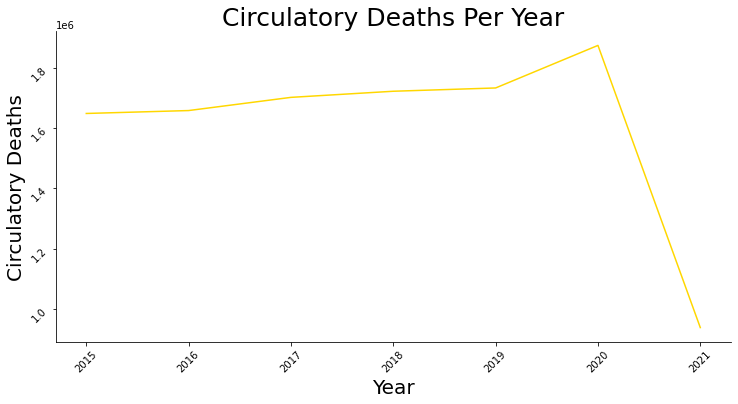

,Malignant
Year,
2015,1196044
2016,1200410
2017,1207174
2018,1207218
2019,1208100
2020,1233371
2021,629774


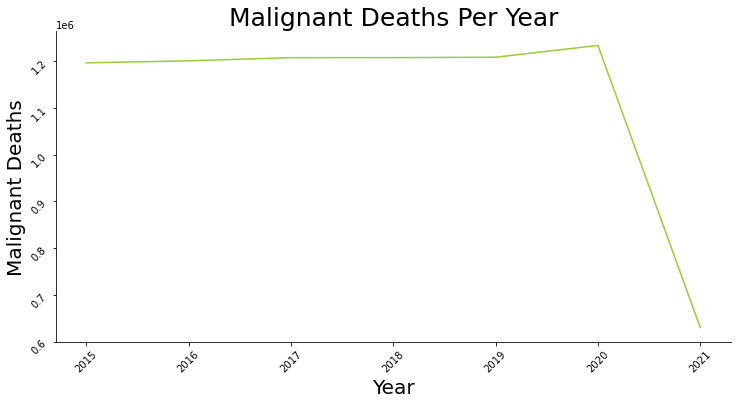

,Respiratory
Year,
2015,520320
2016,512124
2017,539684
2018,547714
2019,523500
2020,532320
2021,239524


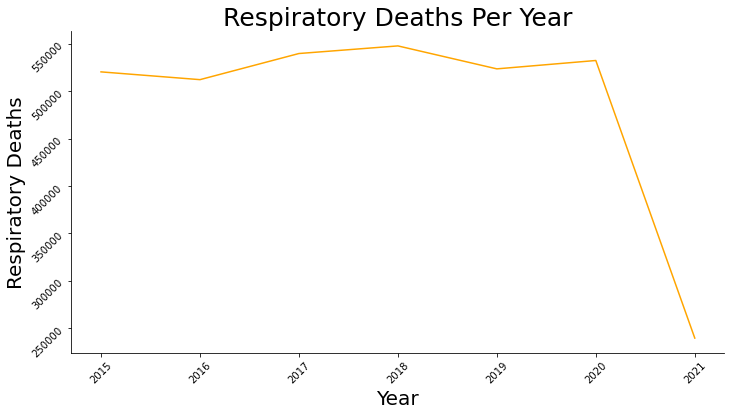

,Alzheimer
Year,
2015,490130
2016,498712
2017,525012
2018,535206
2019,544754
2020,621426
2021,287888


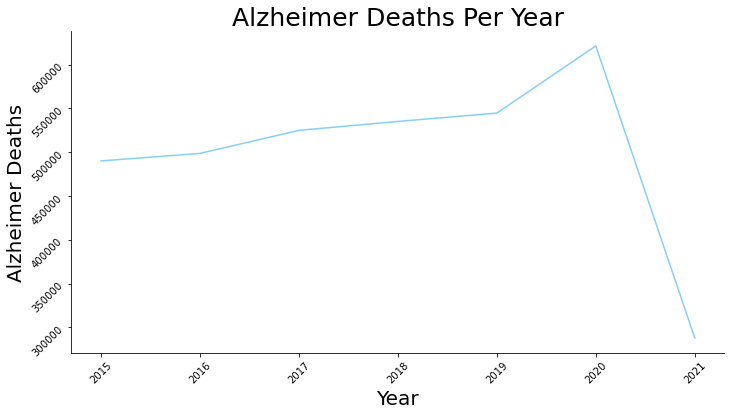

,Other
Year,
2015,314026
2016,315756
2017,326626
2018,330710
2019,331254
2020,373981
2021,187997


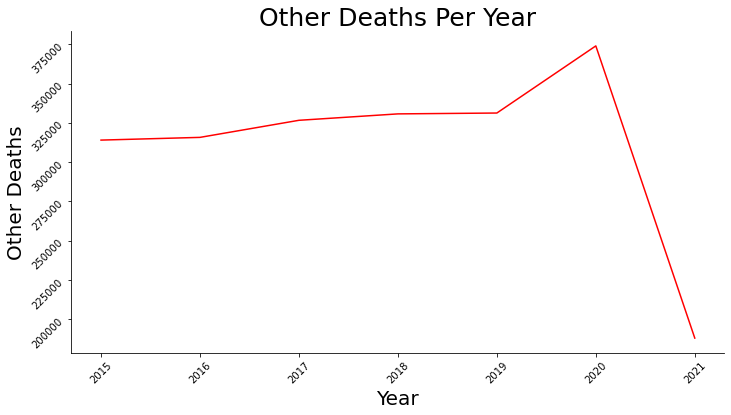

In [22]:
data_circulatory = pd.DataFrame([df_deathsCausePerYear['Year'], df_deathsCausePerYear['Circulatory']])
data_circulatory = data_circulatory.transpose().set_index('Year')
display(data_circulatory)
# Draw Plot
sns.relplot(x=data_circulatory.index, y='Circulatory', kind='line', height=5, aspect=2, color='gold', data=data_circulatory)
plt.title("Circulatory Deaths Per Year", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Circulatory Deaths", size=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

data_malignant = pd.DataFrame([df_deathsCausePerYear['Year'], df_deathsCausePerYear['Malignant']])
data_malignant = data_malignant.transpose().set_index('Year')
display(data_malignant)
# Draw Plot
sns.relplot(x=data_malignant.index, y='Malignant', kind = 'line', height=5, aspect=2, color='yellowgreen', data=data_malignant)
plt.title("Malignant Deaths Per Year", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Malignant Deaths", size=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

data_respiratory = pd.DataFrame([df_deathsCausePerYear['Year'], df_deathsCausePerYear['Respiratory']])
data_respiratory = data_respiratory.transpose().set_index('Year')
display(data_respiratory)
# Draw Plot
sns.relplot(x=data_respiratory.index, y='Respiratory', kind = 'line', height=5, aspect=2, color='orange', data=data_respiratory)
plt.title("Respiratory Deaths Per Year", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Respiratory Deaths", size=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

data_alzheimer = pd.DataFrame([df_deathsCausePerYear['Year'], df_deathsCausePerYear['Alzheimer']])
data_alzheimer = data_alzheimer.transpose().set_index('Year')
display(data_alzheimer)
# Draw Plot
sns.relplot(x=data_alzheimer.index, y='Alzheimer', kind = 'line', height=5, aspect=2, color='lightskyblue', data=data_alzheimer)
plt.title("Alzheimer Deaths Per Year", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Alzheimer Deaths", size=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

data_other = pd.DataFrame([df_deathsCausePerYear['Year'], df_deathsCausePerYear['Other']])
data_other = data_other.transpose().set_index('Year')
display(data_other)
# Draw Plot
sns.relplot(x=data_other.index, y='Other', kind = 'line', height=5, aspect=2, color='red', data=data_other)
plt.title("Other Deaths Per Year", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Other Deaths", size=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


According to the visualizations above, you can see the death trends of every category increase every year except respiratory. This is interesting because in the year 2020, most of the country had lockdown restrictions for the COVID-19 pandemic.

### Total deaths by year and jurisdiction
Lets use Pandas groupby function to get the total deaths by year and jurisdiction.

In [23]:
yearJurisdiction_df = data.groupby(['Year', 'Jurisdiction']).sum()
yearJurisdiction_df


NumberOfDeaths
Year Jurisdiction                 
2015 Alabama                 77032
     Alaska                   2254
     Arizona                 79724
     Arkansas                47900
     California             411494
...                            ...
2021 Virginia                59414
     Washington              46828
     West Virginia           11135
     Wisconsin               41140
     Wyoming                  1649

[371 rows x 1 columns]

### Total deaths by jurisdiction
Now, lets get the total deaths by jurisdiction for all years without the year and sort them. We will drop year index.

In [24]:
jurisdiction_deaths = data.groupby('Jurisdiction', as_index=False).sum()
jurisdiction_deaths.drop('Year', axis = 1, inplace = True)
display(jurisdiction_deaths.head())

jurisdiction_deaths_sorted = jurisdiction_deaths.sort_values('NumberOfDeaths', ascending=False).reset_index(drop=True)
display(jurisdiction_deaths_sorted.head())

,Jurisdiction,NumberOfDeaths
0,Alabama,540055
1,Alaska,14674
2,Arizona,570474
3,Arkansas,324371
4,California,2786428


,Jurisdiction,NumberOfDeaths
0,California,2786428
1,Florida,2091816
2,Texas,2041081
3,Pennsylvania,1369605
4,Ohio,1244729


Lets plot the results in a line plot. We will plot the top 10 and then the bottom 10.

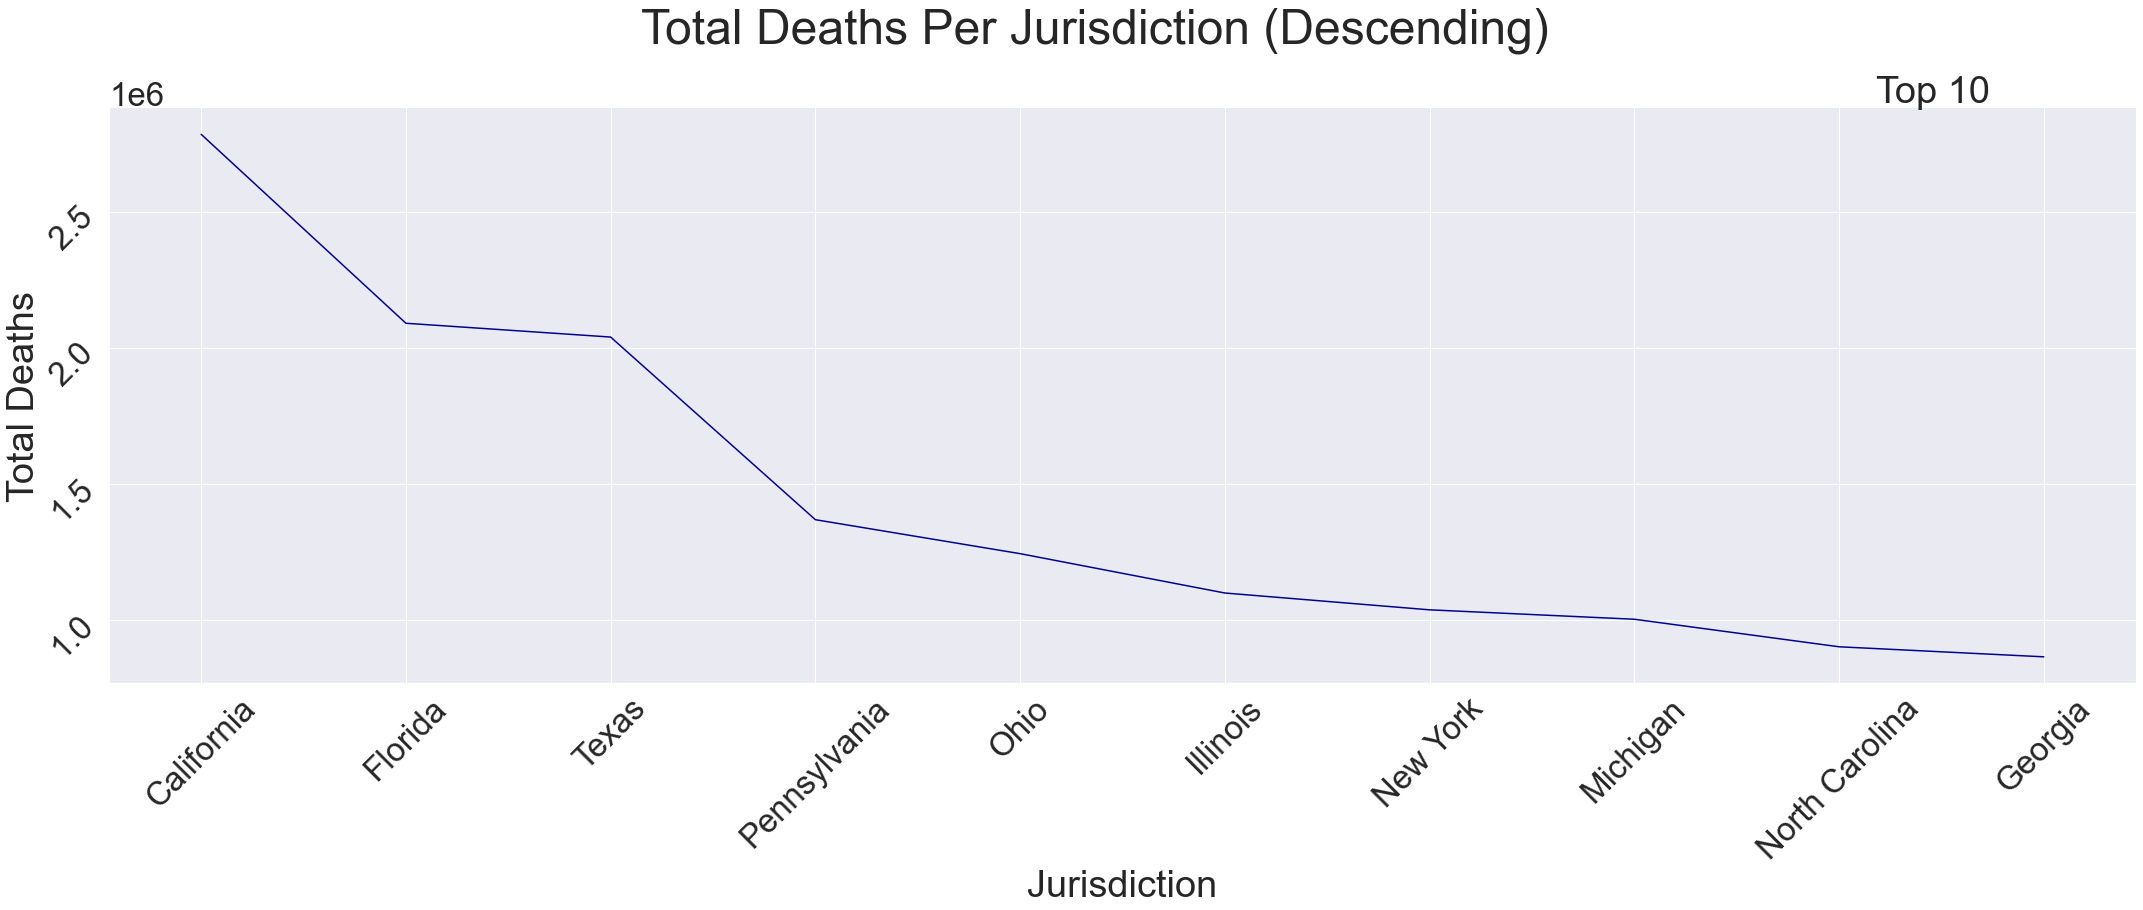

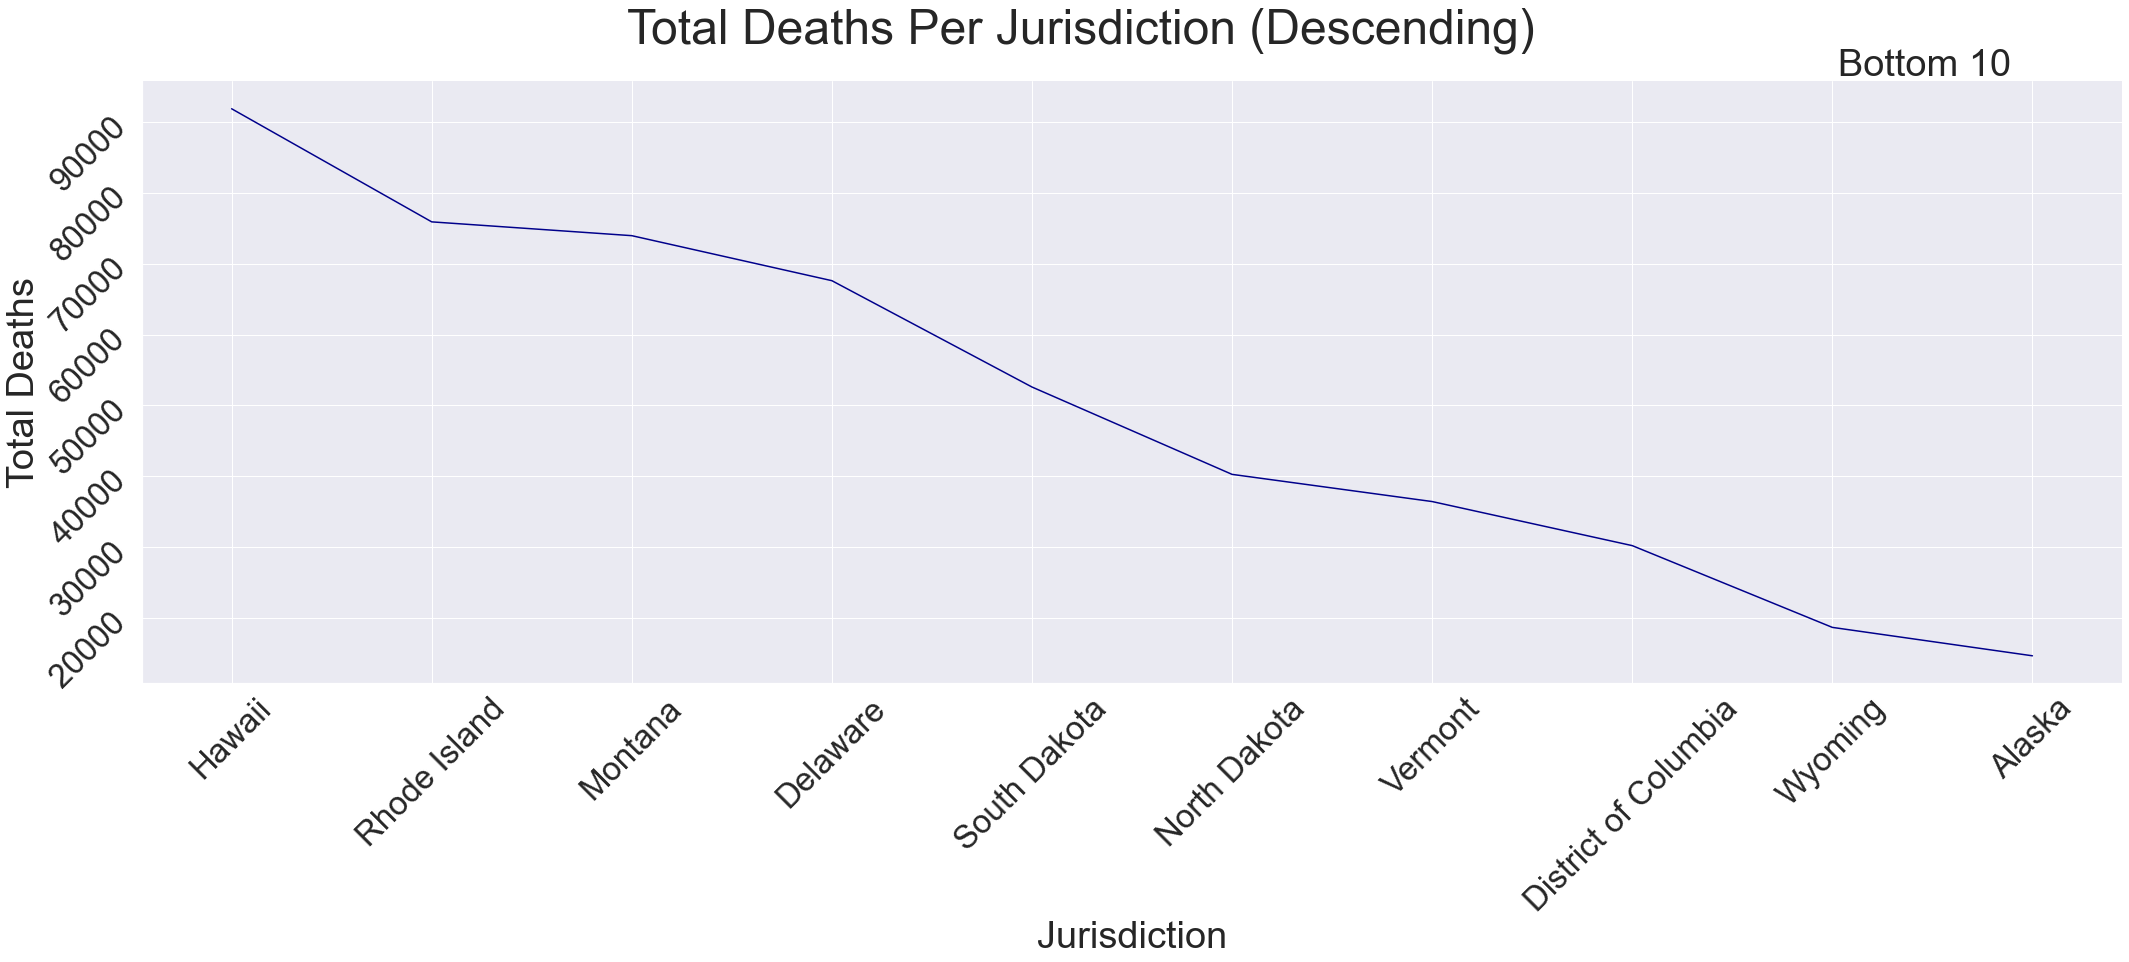

In [25]:
sns.set(font_scale = 3)
sns.relplot(x='Jurisdiction', y='NumberOfDeaths', kind = 'line', height=10, aspect=3, color='darkblue', data=jurisdiction_deaths_sorted.head(10))
plt.suptitle("Total Deaths Per Jurisdiction (Descending)", size=48, y=1.05)
plt.title("Top 10", size=38, x=0.9)
plt.xlabel("Jurisdiction", size=38)
plt.ylabel("Total Deaths", size=38)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

sns.set(font_scale = 3)
sns.relplot(x='Jurisdiction', y='NumberOfDeaths', kind = 'line', height=10, aspect=3, color='darkblue', data=jurisdiction_deaths_sorted.tail(10))
plt.suptitle("Total Deaths Per Jurisdiction (Descending)", size=48, y=1.05)
plt.title("Bottom 10", size=38, x=0.9)
plt.xlabel("Jurisdiction", size=38)
plt.ylabel("Total Deaths", size=38)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### 2020 deaths by jurisdiction sorted from most to least
Now, lets sort the deaths from most to least for the year 2020.

In [26]:
jurisdiction_deaths2020_sorted = yearJurisdiction_df.copy()
jurisdiction_deaths2020_sorted = jurisdiction_deaths2020_sorted.loc[(2020)].sort_values('NumberOfDeaths', ascending=False).reset_index()

# Display the head
display(jurisdiction_deaths2020_sorted.head())

# Display the tail.
display(jurisdiction_deaths2020_sorted.tail())

,Jurisdiction,NumberOfDeaths
0,California,455765
1,Florida,344198
2,Texas,340650
3,Pennsylvania,216632
4,Ohio,201921


,Jurisdiction,NumberOfDeaths
48,North Dakota,6492
49,Vermont,6180
50,District of Columbia,4712
51,Wyoming,3470
52,Alaska,2626


### Plot the Results

Lets plot the results for the year 2020 from most deaths to least deaths in 2 seperate plots. First, we will plot the top 10 and then we will plot the bottom 10.

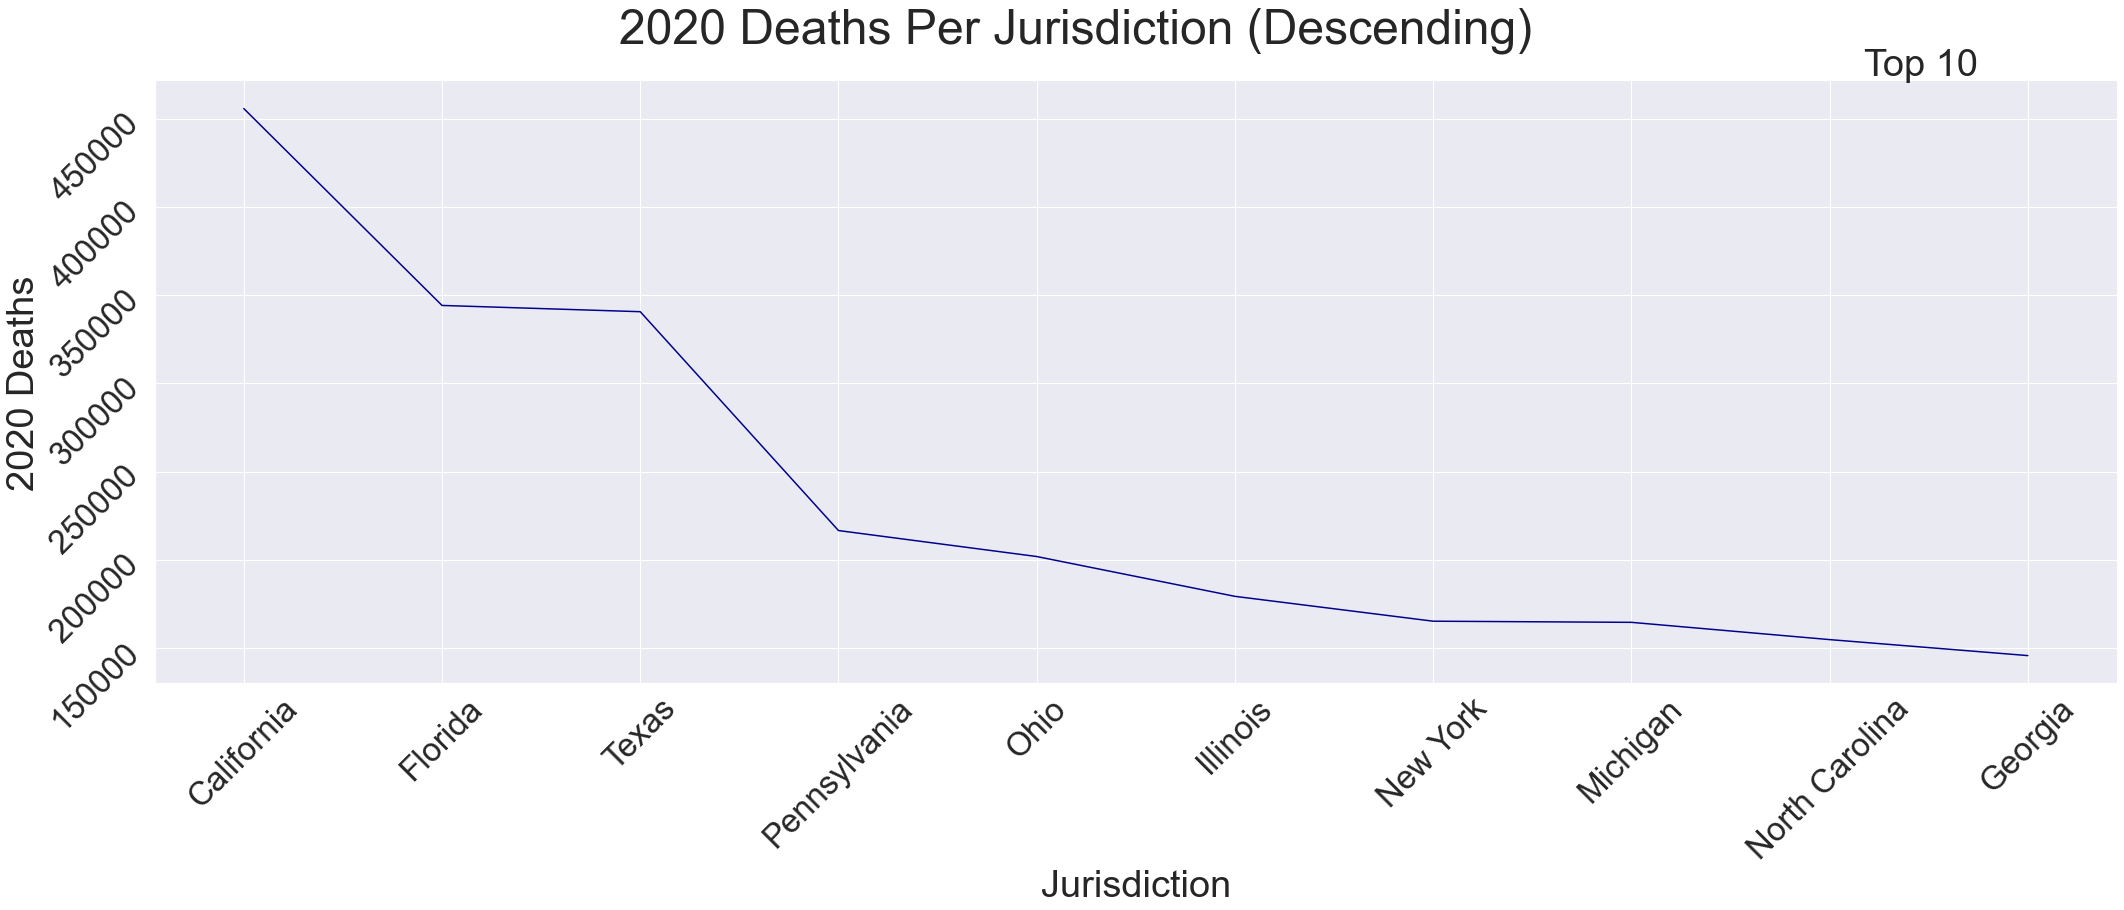

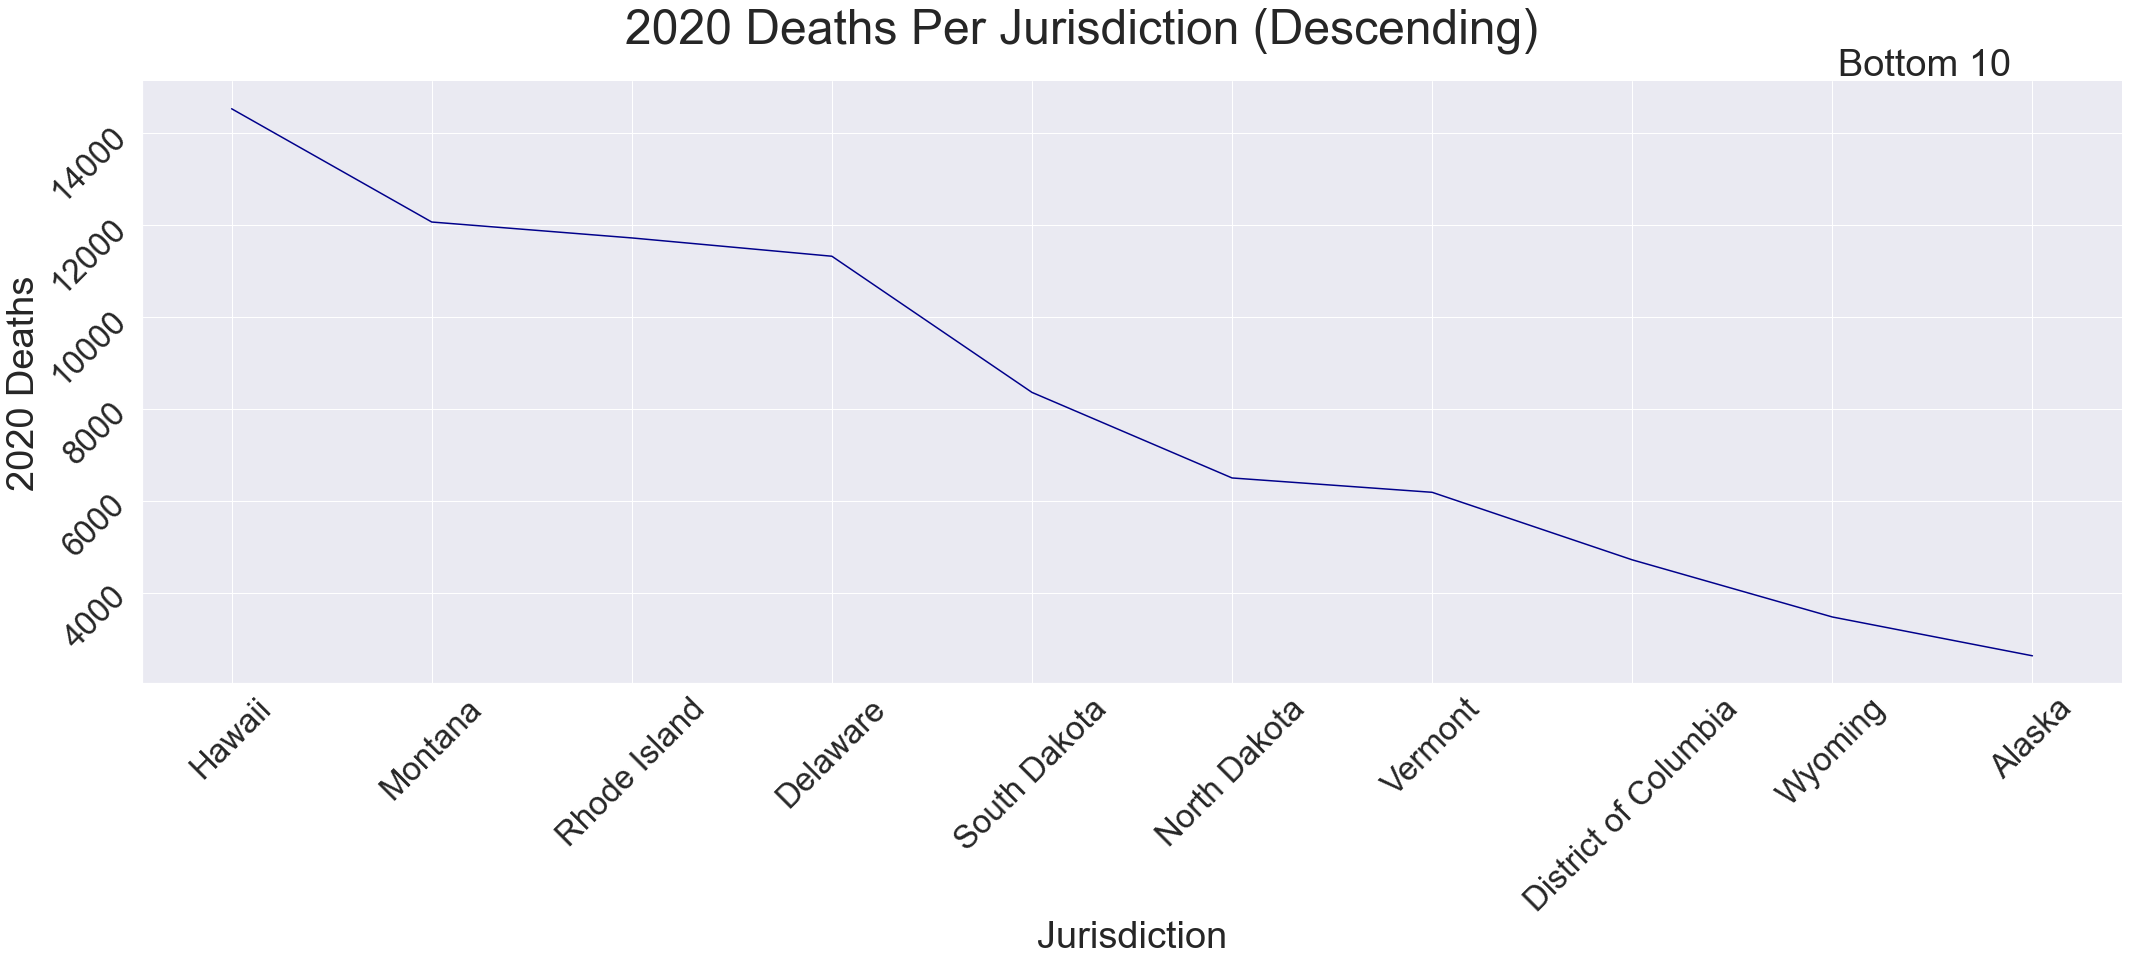

In [27]:
sns.set(font_scale = 3)
sns.relplot(x='Jurisdiction', y='NumberOfDeaths', kind = 'line', height=10, aspect=3, color='darkblue', data=jurisdiction_deaths2020_sorted.head(10))
plt.suptitle("2020 Deaths Per Jurisdiction (Descending)", size=48, y=1.05)
plt.title("Top 10", size=38, x=0.9)
plt.xlabel("Jurisdiction", size=38)
plt.ylabel("2020 Deaths", size=38)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

sns.set(font_scale = 3)
sns.relplot(x='Jurisdiction', y='NumberOfDeaths', kind = 'line', height=10, aspect=3, color='darkblue', data=jurisdiction_deaths2020_sorted.tail(10))
plt.suptitle("2020 Deaths Per Jurisdiction (Descending)", size=48, y=1.05)
plt.title("Bottom 10", size=38, x=0.9)
plt.xlabel("Jurisdiction", size=38)
plt.ylabel("2020 Deaths", size=38)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## Conclusion

- Total deaths from 2015 to present gradually rise. One thought to why this is true is because population increases every year. Population has not been taken into consideration in this analysis.
- Every year in this analysis has about the same proportion death rate per cause.
- Circulatory is the leader in cause of deaths, followed by malignant, followed by alzheimer's, followed by respiratory, followed by other causes of death and this has been the order for every year analyzed in this analyses.